# imports

In [1]:
#!/usr/bin/env python3
"""
Simple SEED-DV EEG Preprocessing Pipeline
Standard preprocessing steps without unnecessary complexity
"""

import os
import numpy as np
import mne
from pathlib import Path
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from mne.preprocessing import ICA
from IPython.display import display

In [2]:
subject = "sub19"

In [3]:
import mne
print(mne.__version__)

1.9.0


In [4]:
# Set MNE logging to reduce output
mne.set_log_level('DEBUG')

In [5]:
# To visualise locally do pip install pytq5 

In [6]:
%matplotlib qt

In [10]:
input_dir = Path("/home/poorna/data/SEED-DV/EEG")
output_dir = Path("preprocessed_eeg2")
output_dir.mkdir(exist_ok=True)

# Basic parameters
sfreq = 200  # Original sampling rate
target_sfreq = 200  # Target sampling rate
n_channels = 62

# Standard 62-channel names
ch_names = [
    'FP1', 'FPZ', 'FP2', 'AF3', 'AF4',
    'F7', 'F5', 'F3', 'F1', 'FZ', 'F2', 'F4', 'F6', 'F8',
    'FT7', 'FC5', 'FC3', 'FC1', 'FCZ', 'FC2', 'FC4', 'FC6', 'FT8',
    'T7', 'C5', 'C3', 'C1', 'CZ', 'C2', 'C4', 'C6', 'T8',
    'TP7', 'CP5', 'CP3', 'CP1', 'CPZ', 'CP2', 'CP4', 'CP6', 'TP8',
    'P7', 'P5', 'P3', 'P1', 'PZ', 'P2', 'P4', 'P6', 'P8',
    'PO7', 'PO5', 'PO3', 'POZ', 'PO4', 'PO6', 'PO8',
    'CB1', 'O1', 'OZ', 'O2', 'CB2'
]

# find_subject_files()

In [11]:
def find_subject_files():
    """Find all subject .npy files."""
    files = list(input_dir.glob("*.npy"))
    subjects = {}
    
    for file in files:
        subject_id = file.stem
        subjects[subject_id] = file
    
    return subjects

In [12]:
subjects = find_subject_files()
print(subjects)

{'sub1': PosixPath('/home/poorna/data/SEED-DV/EEG/sub1.npy'), 'sub10': PosixPath('/home/poorna/data/SEED-DV/EEG/sub10.npy'), 'sub11': PosixPath('/home/poorna/data/SEED-DV/EEG/sub11.npy'), 'sub12': PosixPath('/home/poorna/data/SEED-DV/EEG/sub12.npy'), 'sub13': PosixPath('/home/poorna/data/SEED-DV/EEG/sub13.npy'), 'sub14': PosixPath('/home/poorna/data/SEED-DV/EEG/sub14.npy'), 'sub15': PosixPath('/home/poorna/data/SEED-DV/EEG/sub15.npy'), 'sub16': PosixPath('/home/poorna/data/SEED-DV/EEG/sub16.npy'), 'sub17': PosixPath('/home/poorna/data/SEED-DV/EEG/sub17.npy'), 'sub18': PosixPath('/home/poorna/data/SEED-DV/EEG/sub18.npy'), 'sub19': PosixPath('/home/poorna/data/SEED-DV/EEG/sub19.npy'), 'sub1_session2': PosixPath('/home/poorna/data/SEED-DV/EEG/sub1_session2.npy'), 'sub2': PosixPath('/home/poorna/data/SEED-DV/EEG/sub2.npy'), 'sub20': PosixPath('/home/poorna/data/SEED-DV/EEG/sub20.npy'), 'sub3': PosixPath('/home/poorna/data/SEED-DV/EEG/sub3.npy'), 'sub4': PosixPath('/home/poorna/data/SEED-DV

# load_data()

In [13]:
def load_data(file_path):
    """Load and reshape SEED-DV data."""
    print(f"  Loading: {file_path.name}")
    data = np.load(file_path)  # Shape: (7_videos, 62_channels, timepoints)
    
    # Reshape to (channels, timepoints)
    n_videos, n_channels, n_timepoints = data.shape
    reshaped_data = data.transpose(1, 0, 2).reshape(n_channels, -1)
    
    print(f"  Original shape: {data.shape}")
    print(f"  Reshaped to: {reshaped_data.shape}")
    
    return reshaped_data

In [14]:
reshaped_data = load_data(subjects[subject])

  Loading: sub19.npy
  Original shape: (7, 62, 104000)
  Reshaped to: (62, 728000)


# create_raw_object()

In [15]:
def create_raw_object(data):
    """Create MNE Raw object."""
    # Create info
    info = mne.create_info(
        ch_names=ch_names[:n_channels],
        sfreq=sfreq,
        ch_types=['eeg'] * n_channels
    )
    
    # Create Raw object
    raw = mne.io.RawArray(data, info)
    
    # Set standard montage
    montage = mne.channels.make_standard_montage('standard_1020')
    raw.set_montage(montage, match_case=False, on_missing='ignore')
    
    return raw

## custom using read_custom_montage() file

In [18]:
def create_raw_object(data):
    """Create MNE Raw object."""
    # Create info
    info = mne.create_info(
        ch_names=ch_names[:n_channels],
        sfreq=sfreq,
        ch_types=['eeg'] * n_channels
    )
    
    # Create Raw object
    raw = mne.io.RawArray(data, info)
    
    # Set standard montage
    montage = mne.channels.read_custom_montage("/home/poorna/data/SEED-DV/channel_62_pos.locs")
    raw.set_montage(montage, match_case=False, on_missing='ignore')
    
    return raw

In [19]:
raw_data = create_raw_object(reshaped_data)
raw_before = raw_data.copy()

Creating RawArray with float64 data, n_channels=62, n_times=728000
    Range : 0 ... 727999 =      0.000 ...  3639.995 secs
Ready.


Using matplotlib as 2D backend.
Opening raw browser...
Showing plot for backend 'qtagg'
Closing raw browser...
Channels marked as bad:
['CZ', 'CPZ', 'PZ', 'P2']


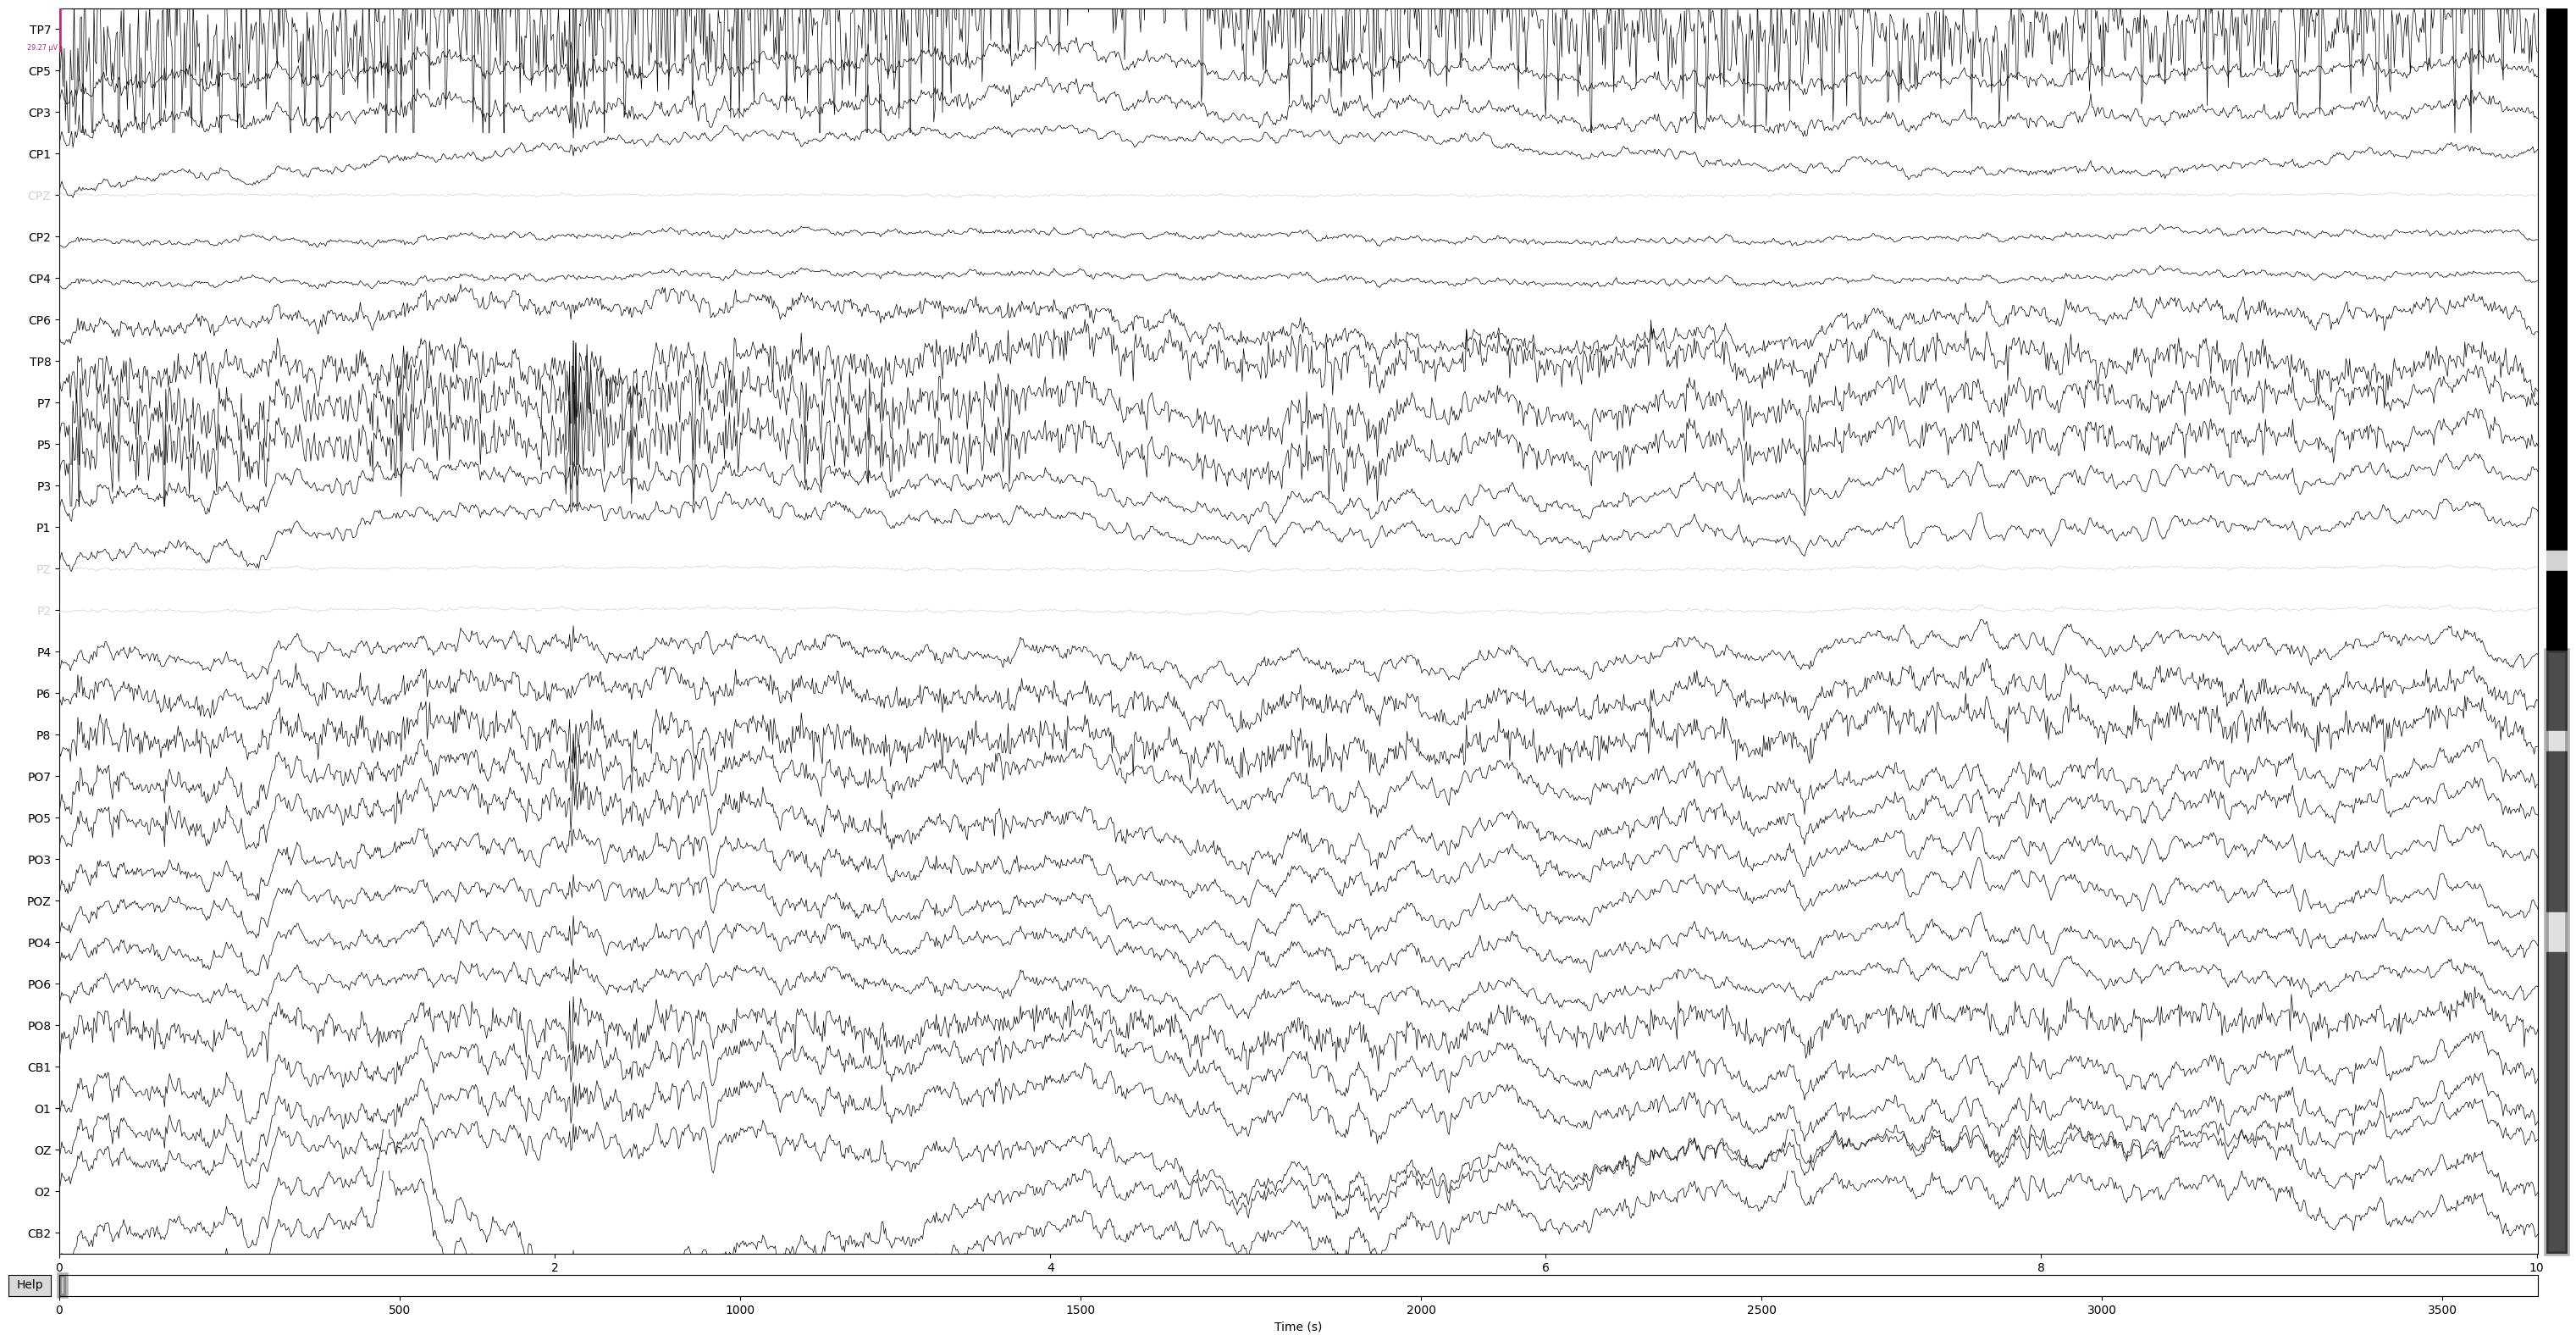

In [20]:
raw_data.plot(
    n_channels=30,        # number of channels to display at once
    scalings='auto',      # or {'eeg': 20e-6} to manually set
    duration=10.0,        # time (in seconds) to show per window
    start=0.0,            # start time (in seconds)
    show=True,            # display immediately
    block=True,           # block execution until closed
    title='EEG Raw Data'  # plot window title
)


In [21]:
raw_data.info["bads"]

['CZ', 'CPZ', 'PZ', 'P2']

Generating pos outlines with sphere [0.    0.    0.    0.095] from [0.    0.    0.    0.095] for eeg
Generating coords using: [0.    0.    0.    0.095]
Showing plot for backend 'qtagg'


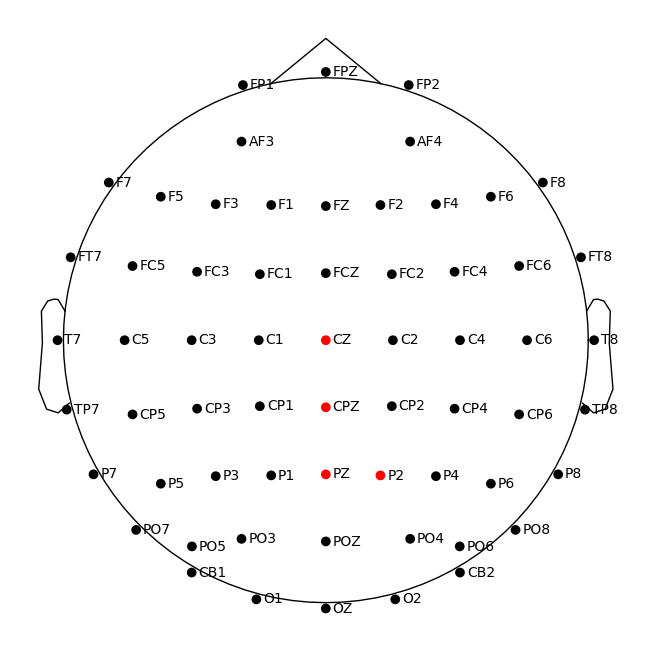

In [22]:
raw_data.plot_sensors(kind="topomap",show_names= True)

# apply_filters()

Effective window size : 10.240 (s)
Spectogram using 2048-point FFT on 2048 samples with 0 overlap and hamming window
Plotting power spectral density (dB=True).
Generating pos outlines with sphere [0.    0.    0.    0.095] from [0.    0.    0.    0.095] for eeg
Generating coords using: [0.    0.    0.    0.095]
Showing plot for backend 'qtagg'


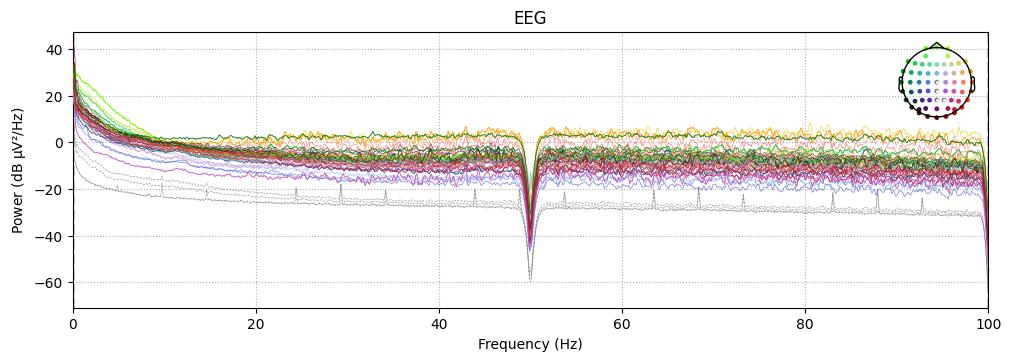

In [23]:
raw_data.compute_psd().plot()

In [24]:
raw_data.info["bads"]

['CZ', 'CPZ', 'PZ', 'P2']

In [25]:
# EEG Filtering Justification:
# - We apply a bandpass filter from 0.5 to 40 Hz:
#   This range preserves the main EEG bands (theta, alpha, beta) relevant for cognitive and motor tasks.
#   It removes slow drifts (<0.5 Hz) and high-frequency muscle artifacts and noise (>40 Hz, including gamma).
# - A 50 Hz notch filter is used to remove power line interference, common in many countries.
# - These settings are appropriate for training models that decode text or cognitive intent from EEG signals.

def apply_filters(raw):
    """
    Apply preprocessing filters to EEG data.
    """
    print("  Applying filters...")
    print("  Received bad channels:", raw.info['bads'])

    # Bandpass filter between 0.5 and 40 Hz to retain useful EEG bands
    raw.filter(
        l_freq=0.5,             # Remove slow drifts
        h_freq=40.0,            # Exclude high-frequency noise (gamma, EMG)
        fir_design='firwin',    # Linear-phase FIR filter
        skip_by_annotation='edge'# Avoid filtering edges marked as bad
    )

    # Notch filter at 50 Hz to eliminate power line interference
    raw.notch_filter(
        freqs=50.0,
        fir_design='firwin'
    )

    return raw


In [26]:
filtered_data = apply_filters(raw_data)

  Applying filters...
  Received bad channels: ['CZ', 'CPZ', 'PZ', 'P2']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1321 samples (6.605 s)

Using filter length: 1321
Smart-padding with:  1320 samples on each edge
FFT block length:   8192
Got 1 parallel jobs after requesting None


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 s)

Using filter length: 1321
Smart-padding with:  1320 samples on each edge
FFT block length:   8192
Got 1 parallel jobs after requesting None


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Effective window size : 10.240 (s)
Spectogram using 2048-point FFT on 2048 samples with 0 overlap and hamming window
Plotting power spectral density (dB=True).
Generating pos outlines with sphere [0.    0.    0.    0.095] from [0.    0.    0.    0.095] for eeg
Generating coords using: [0.    0.    0.    0.095]
Showing plot for backend 'qtagg'


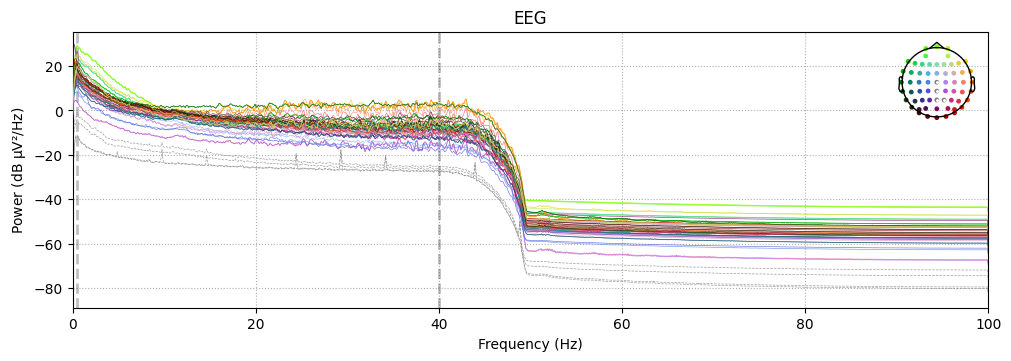

In [27]:
filtered_data.compute_psd().plot()

In [28]:
filtered_data.info["bads"]

['CZ', 'CPZ', 'PZ', 'P2']

# detect_bad_channels()

In [29]:
def detect_bad_channels(raw, std_multiplier=3.0):
    """
    Detects bad EEG channels based on signal variance and interpolates them in-place
    in the original raw object. Shows original vs interpolated for visual comparison.

    Parameters:
    - raw: mne.io.Raw
    - std_multiplier: float, threshold multiplier for standard deviation

    Returns:
    - raw: mne.io.Raw (with interpolated bad channels if found)
    """
    print("  Detecting bad channels...")

    # Make a copy for safe processing
    raw_copy = raw.copy()
    eeg_data = raw_copy.pick(picks="eeg")

    # Compute standard deviation for each EEG channel
    data = eeg_data.get_data()
    channel_stds = np.std(data, axis=1)
    mean_std = np.mean(channel_stds)
    std_threshold = std_multiplier * np.std(channel_stds)

    # Find channels with unusually high/low variance
    bad_channels = [
        ch_name
        for ch_name, ch_std in zip(eeg_data.ch_names, channel_stds)
        if ch_std > mean_std + std_threshold or ch_std < mean_std - std_threshold
    ]

    # Include any channels already marked as bad
    bad_channels = list(set(bad_channels + raw.info["bads"]))

    if bad_channels:
        print(f"    Found {len(bad_channels)} bad channels: {bad_channels}")

        # For visualization only — do not reuse this for interpolation
        raw_viz = raw.copy()
        raw_viz.info['bads'] = bad_channels
        raw_interp_viz = raw_viz.copy().interpolate_bads(reset_bads=False)

        # Show original and interpolated for comparison
        for title, data in zip(["Original (with bads)", "Interpolated"], [raw_viz, raw_interp_viz]):
            with mne.viz.use_browser_backend("matplotlib"):
                fig = data.plot(butterfly=True, color="#00000022", bad_color="r")
            fig.subplots_adjust(top=0.9)
            fig.suptitle(title, size="xx-large", weight="bold")

        # Safety check before modifying original
        if np.isnan(raw_interp_viz.get_data()).any() or np.isinf(raw_interp_viz.get_data()).any():
            print("❗ Interpolated data contains NaNs or Infs — skipping update to original data.")
        else:
            # Apply bads and interpolate in original raw object
            raw.info['bads'] = bad_channels
            raw.interpolate_bads(reset_bads=True)
            print("→ Interpolation applied to original data.")
    else:
        print("    No bad channels detected.")

    return raw

In [30]:
bad_channels_detected = detect_bad_channels(filtered_data)

  Detecting bad channels...
    Found 7 bad channels: ['FPZ', 'FP1', 'CZ', 'CPZ', 'P2', 'FP2', 'PZ']
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 55 sensor positions
Interpolating 7 sensors
Opening raw browser...
Showing plot for backend 'qtagg'
Opening raw browser...
Showing plot for backend 'qtagg'
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 55 sensor positions
Interpolating 7 sensors
→ Interpolation applied to original data.


In [26]:
bad_channels_detected.info["bads"]

[]

# apply_reference()

In [27]:
def apply_reference(raw):
    """Apply common average reference."""
    print("  Applying common average reference...")
    raw.set_eeg_reference(ref_channels='average', projection=True)
    raw.apply_proj()
    return raw

In [28]:
rereferenced_data = apply_reference(bad_channels_detected)

  Applying common average reference...
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...


In [29]:
rereferenced_data.info["bads"]

[]

Effective window size : 10.240 (s)
Spectogram using 2048-point FFT on 2048 samples with 0 overlap and hamming window
Plotting power spectral density (dB=True).
Generating pos outlines with sphere [0.    0.    0.    0.095] from [0.    0.    0.    0.095] for eeg
Generating coords using: [0.    0.    0.    0.095]
Showing plot for backend 'qtagg'


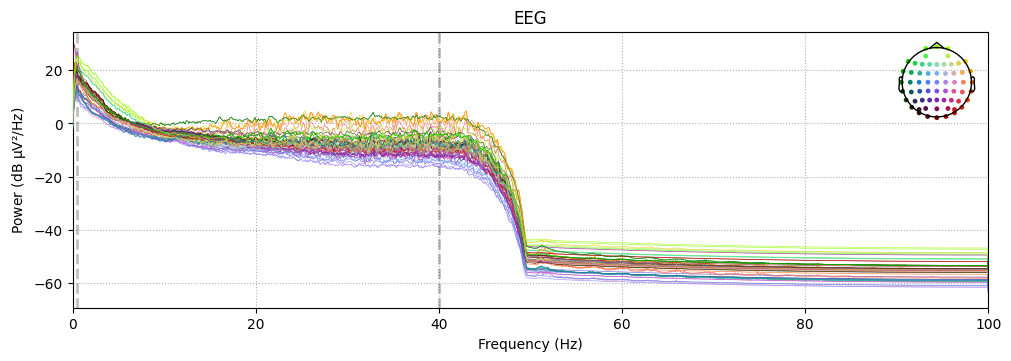

Closing <MNELineFigure size 1000x351 with 2 Axes>


In [30]:
rereferenced_data.compute_psd().plot()

# apply_ica()

In [31]:
def apply_ica(raw):
    """
    Apply ICA with optional manual exclusion. Use in Jupyter by visually inspecting components.
    Returns:
        raw_clean: ICA-cleaned raw object
        ica: the fitted ICA object
    """
    import matplotlib.pyplot as plt
    from mne.preprocessing import ICA

    print("  Applying ICA...")

    ica = ICA(n_components=20, random_state=42, method='fastica')
    ica.fit(raw)

    # Try detecting EOG-related components using Fp1 and Fp2
    eog_inds = []
    for ch in ['FP1', 'FP2']:
        try:
            inds, scores = ica.find_bads_eog(raw, ch_name=ch, threshold=3.0)
            if inds:
                print(f"    Auto-detected EOG components from {ch}: {inds}")
                eog_inds.extend(inds)
                ica.plot_scores(scores, ch_name=ch)
                plt.show()
        except Exception as e:
            print(f"    EOG detection failed for {ch}: {e}")

    if eog_inds:
        ica.exclude = list(set(eog_inds))
        print(f"    Components auto-marked for exclusion: {ica.exclude}")
    else:
        print("    No EOG-like components auto-detected.")

    # Plot components for visual inspection
    ica.plot_components(inst=raw)
    plt.show()

    # Apply ICA and return
    raw_clean = ica.apply(raw.copy())
    return raw_clean, ica

In [32]:
raw_clean, ica = apply_ica(rereferenced_data)

  Applying ICA...
Fitting ICA to data using 62 channels (please be patient, this may take a while)
    Applying projection operator with 1 vector (pre-whitener computation)
    Applying projection operator with 1 vector (pre-whitener application)
Selecting by number: 20 components
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 12.8s.
Using EOG channel: FP1
    Applying projection operator with 1 vector (pre-whitener application)
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2000 samples (10.000 s)

Using filter

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


    Auto-detected EOG components from FP1: [0]
    EOG detection failed for FP1: ICA.plot_scores() got an unexpected keyword argument 'ch_name'
Using EOG channel: FP2
    Applying projection operator with 1 vector (pre-whitener application)
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2000 samples (10.000 s)

Using filter length: 2048
Smart-padding with:  2047 samples on each edge
FFT block length:   32768
Got 1 parallel jobs after requesting None
... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
--------------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


    Auto-detected EOG components from FP2: [0, 1]
    EOG detection failed for FP2: ICA.plot_scores() got an unexpected keyword argument 'ch_name'
    Components auto-marked for exclusion: [0, 1]
Generating coords using: [0.    0.    0.    0.095]
Generating coords using: [0.    0.    0.    0.095]
Plotting topomap for eeg data shape (62,)
Interpolation mode cubic, extrapolation mode head to mean
Plotting topomap for eeg data shape (62,)
Interpolation mode cubic, extrapolation mode head to mean
Plotting topomap for eeg data shape (62,)
Interpolation mode cubic, extrapolation mode head to mean
Plotting topomap for eeg data shape (62,)
Interpolation mode cubic, extrapolation mode head to mean
Plotting topomap for eeg data shape (62,)
Interpolation mode cubic, extrapolation mode head to mean
Plotting topomap for eeg data shape (62,)
Interpolation mode cubic, extrapolation mode head to mean
Plotting topomap for eeg data shape (62,)
Interpolation mode cubic, extrapolation mode head to mean
Pl

In [33]:
# fig = ica.plot_components(inst=raw_clean)
# display(fig)

In [34]:
ica.plot_sources(raw_clean)
# After selecting and closing the window...
print("Selected (excluded) components:", ica.exclude)

# Then apply ICA
raw_clean = ica.apply(raw_clean)

    Applying projection operator with 1 vector (pre-whitener application)
Creating RawArray with float64 data, n_channels=20, n_times=728000
    Range : 0 ... 727999 =      0.000 ...  3639.995 secs
Ready.
Opening ica browser...
Showing plot for backend 'qtagg'
Selected (excluded) components: [0, 1]
Applying ICA to Raw instance
    Applying projection operator with 1 vector (pre-whitener application)
    Transforming to ICA space (20 components)
    Zeroing out 2 ICA components
    Projecting back using 62 PCA components
Closing ica browser...


<Info | 9 non-empty values
 bads: []
 ch_names: FP1, FPZ, FP2, AF3, AF4, F7, F5, F3, F1, FZ, F2, F4, F6, F8, ...
 chs: 62 EEG
 custom_ref_applied: False
 dig: 65 items (3 Cardinal, 62 EEG)
 highpass: 0.5 Hz
 lowpass: 40.0 Hz
 meas_date: unspecified
 nchan: 62
 projs: Average EEG reference: on
 sfreq: 200.0 Hz
>
Opening raw browser...
Showing plot for backend 'qtagg'


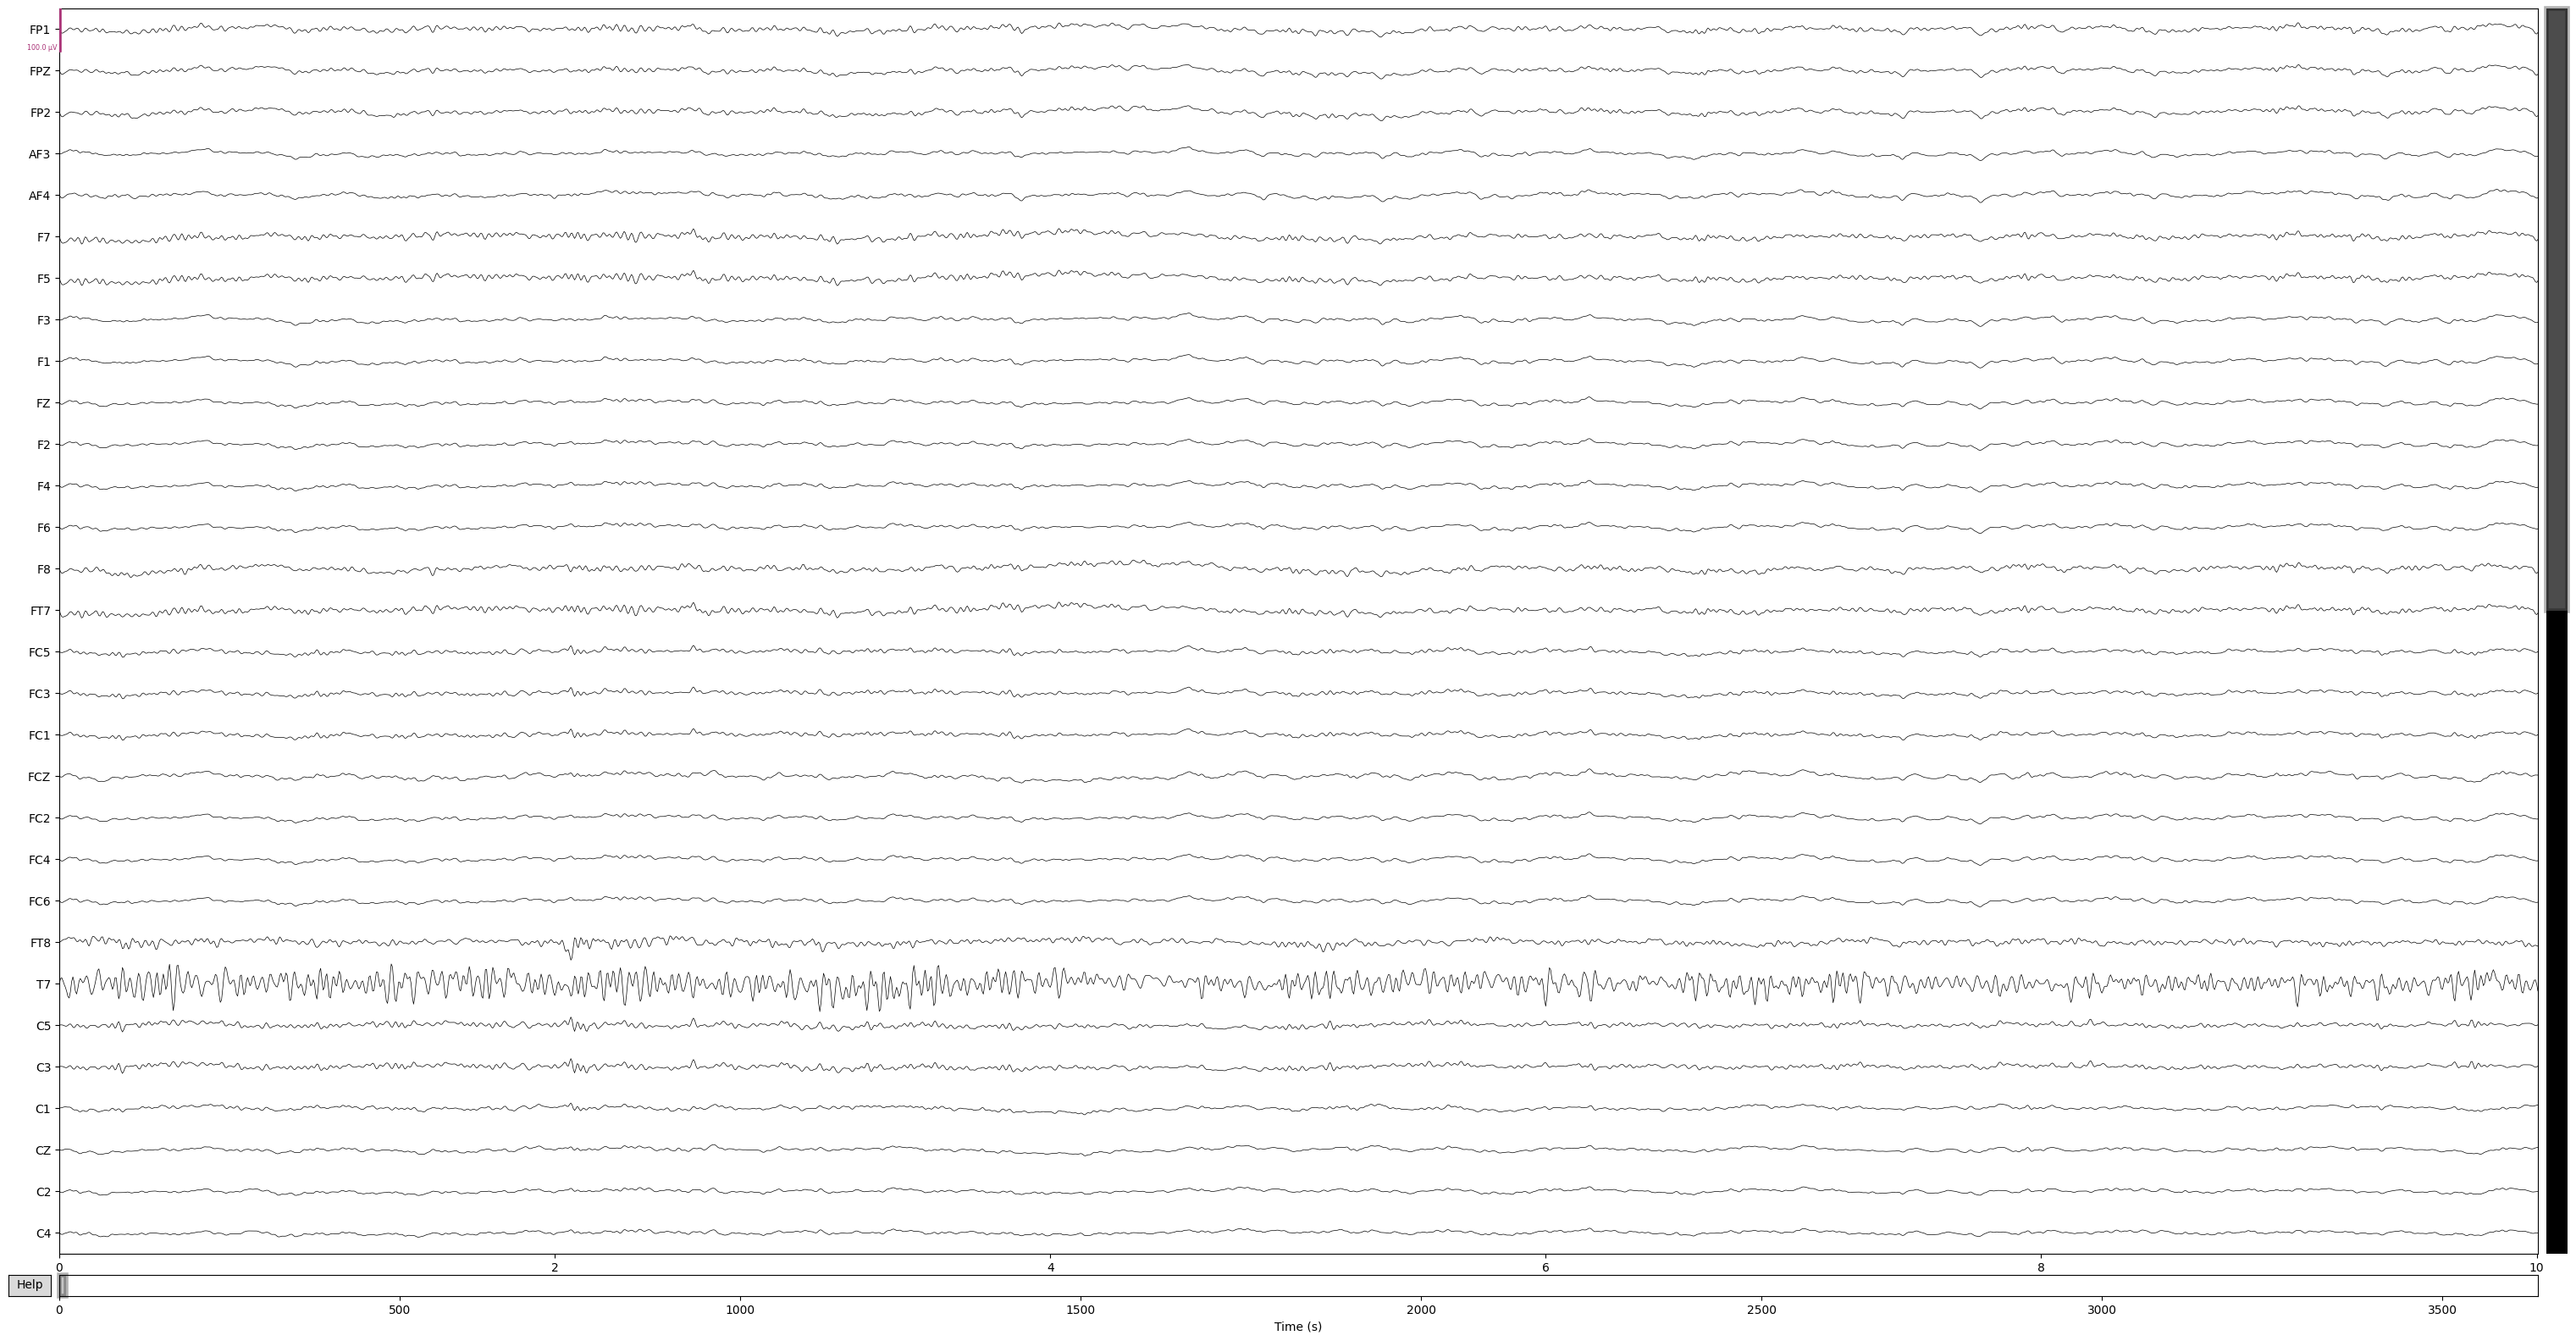

Closing raw browser...
Channels marked as bad:
none


In [35]:
raw_clean.info['bads']
print(raw_clean.info)
raw_clean.plot(duration=10, n_channels=30, scalings={'eeg': 50e-6}) # Plot a segment

# create_epochs()

In [36]:
def create_epochs( raw):
    """Create 13s epochs per block and mark end of 3s hint within each epoch."""
    print("  Creating block-level epochs with hint-end markers...")

    sfreq = raw.info['sfreq']
    block_duration = 13.0
    hint_duration = 3.0
    n_blocks = 40

    events = []

    for i in range(n_blocks):
        block_start = i * block_duration
        block_start_sample = int(block_start * sfreq)
        hint_end_sample = block_start_sample + int(hint_duration * sfreq)

        # Event 1: Start of epoch (we'll use this to define the epoch)
        events.append([block_start_sample, 0, 1])   # event_id=1 means 'block_start'

        # Event 2: Hint ends at 3s after block start (within epoch)
        events.append([hint_end_sample, 0, 2])      # event_id=2 means 'hint_end'

    events = np.array(events)
    print(f"    Created {n_blocks} epochs and {n_blocks} hint-end markers")

    # Select only 'block_start' events to create epochs
    epochs = mne.Epochs(
        raw,
        events,
        event_id={'block_start': 1, 'hint_end': 2},
        tmin=0.0,
        tmax=block_duration,
        baseline=None,
        preload=True
    )

    print(f"    Created {len(epochs)} epochs (13s each)")
    return epochs

In [37]:
epochs = create_epochs(raw_clean)

  Creating block-level epochs with hint-end markers...
    Created 40 epochs and 40 hint-end markers
Not setting metadata
80 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 80 events and 2601 original time points ...
    Getting epoch for 0-2601
    Getting epoch for 600-3201
    Getting epoch for 2600-5201
    Getting epoch for 3200-5801
    Getting epoch for 5200-7801
    Getting epoch for 5800-8401
    Getting epoch for 7800-10401
    Getting epoch for 8400-11001
    Getting epoch for 10400-13001
    Getting epoch for 11000-13601
    Getting epoch for 13000-15601
    Getting epoch for 13600-16201
    Getting epoch for 15600-18201
    Getting epoch for 16200-18801
    Getting epoch for 18200-20801
    Getting epoch for 18800-21401
    Getting epoch for 20800-23401
    Getting epoch for 21400-24001
    Getting epoch for 23400-26001
    Getting epoch for 24000-26601
    

In [38]:
# epochs.plot()

In [39]:
epochs

<Epochs | 80 events (all good), 0 – 13 s (baseline off), ~98.5 MiB, data loaded,
 'block_start': 40
 'hint_end': 40>

# normalize_data()

In [40]:
def normalize_data( epochs):
    """Simple z-score normalization."""
    print("  Normalizing data...")
    
    data = epochs.get_data()  # (n_epochs, n_channels, n_times)
    
    # Z-score normalization per channel
    for ch_idx in range(data.shape[1]):
        channel_data = data[:, ch_idx, :].flatten()
        mean_val = np.mean(channel_data)
        std_val = np.std(channel_data)
        
        if std_val > 0:
            data[:, ch_idx, :] = (data[:, ch_idx, :] - mean_val) / std_val
    
    epochs._data = data
    return epochs

In [41]:
normalized_epochs = normalize_data(epochs)

  Normalizing data...
Data is self data: True
  Copying, copy=True


In [42]:
# normalized_epochs.plot(scalings="auto")

# save_data()

In [43]:
def save_data( epochs, subject_id):
    """Save preprocessed data."""
    print("  Saving data...")
    
    data = epochs.get_data()
    
    # Save numpy array
    output_file = output_dir /f"{subject_id}_preprocessed.npy"
    np.save(output_file, data)
    
    # Save metadata
    metadata = {
        'subject_id': subject_id,
        'shape': data.shape,
        'sfreq': epochs.info['sfreq'],
        'ch_names': epochs.ch_names,
        'n_epochs': len(epochs),
        'preprocessing_steps': [
            'bandpass_filter_0.5_40Hz',
            'notch_filter_50Hz',
            'common_average_reference',
            'bad_channel_detection',
            'ICA_artifact_removal',
            'epoching_13s',
            'z_score_normalization'
        ]
    }
    
    metadata_file = output_dir / f"{subject_id}_metadata.npy"
    np.save(metadata_file, metadata)
    
    print(f"    Saved: {output_file}")
    print(f"    Shape: {data.shape}")
    
    return output_file

In [44]:
output_file = save_data(normalized_epochs,subject)

  Saving data...
Data is self data: True
  Copying, copy=True
    Saved: preprocessed_eeg/sub19_preprocessed.npy
    Shape: (80, 62, 2601)


# plot_comparision()

In [45]:
def plot_comparison(raw_before, raw_after, subject_id):
    """
    Plot comparison of EEG data before and after preprocessing.

    - Left subplot: Power Spectral Density (PSD) before vs. after
    - Right subplot: Time-series of a selected channel (e.g., Cz) before vs. after

    Saves the resulting plot as a PNG.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import mne

    print("  Creating comparison plot...")

    try:
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        # PSD plot
        psd_before, freqs_before = mne.time_frequency.psd_array_welch(
            raw_before.get_data(), sfreq=raw_before.info['sfreq'], fmin=0.5, fmax=80
        )
        psd_after, freqs_after = mne.time_frequency.psd_array_welch(
            raw_after.get_data(), sfreq=raw_after.info['sfreq'], fmin=0.5, fmax=80
        )

        axes[0].semilogy(freqs_before, np.mean(psd_before, axis=0), 'r-', label='Before', alpha=0.7)
        axes[0].semilogy(freqs_after, np.mean(psd_after, axis=0), 'b-', label='After', alpha=0.7)
        axes[0].set_xlabel('Frequency (Hz)')
        axes[0].set_ylabel('Power Spectral Density (V²/Hz)')
        axes[0].set_title('Power Spectral Density')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

        # Time series plot (first 10 seconds)
        duration = 10  # seconds
        n_samples = int(duration * raw_before.info['sfreq'])
        time_vec = np.arange(n_samples) / raw_before.info['sfreq']

        # Choose 'Cz' channel if available, else use the first channel
        ch_idx = raw_before.ch_names.index('F3') if 'F3' in raw_before.ch_names else 0
        ch_name = raw_before.ch_names[ch_idx]

        before_data = raw_before.get_data()[ch_idx, :n_samples] * 1e6  # in µV
        after_data = raw_after.get_data()[ch_idx, :n_samples] * 1e6    # in µV

        axes[1].plot(time_vec, before_data, 'r-', label='Before', alpha=0.7)
        axes[1].plot(time_vec, after_data, 'b-', label='After', alpha=0.7)
        axes[1].set_xlabel('Time (s)')
        axes[1].set_ylabel('Amplitude (µV)')
        axes[1].set_title(f'Time Series - Channel: {ch_name}')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)

        plt.tight_layout()

        # Save comparison figure
        plot_file = output_dir / f"{subject_id}_comparison.png"
        plt.savefig(plot_file, dpi=150, bbox_inches='tight')
        plt.close()

        print(f"    Saved plot: {plot_file}")

    except Exception as e:
        print(f"    Error creating plot: {e}")

In [46]:
plot_comparison(raw_before,raw_clean,subject)

  Creating comparison plot...
Effective window size : 1.280 (s)
Spectogram using 256-point FFT on 256 samples with 0 overlap and hamming window
Got 1 parallel jobs after requesting None
Effective window size : 1.280 (s)
Spectogram using 256-point FFT on 256 samples with 0 overlap and hamming window
Got 1 parallel jobs after requesting None
    Saved plot: preprocessed_eeg/sub19_comparison.png


In [7]:
import numpy as np

preprocessed_data = np.load("./preprocessed_eeg/sub1/sub1_preprocessed.npy")

block_start_epochs_data = preprocessed_data[::2]

In [8]:
print("Loaded data shape:", block_start_epochs_data.shape)

Loaded data shape: (40, 62, 2601)
